# Training:

This project uses a machine learning model of classification and segmentation. It is based on a U-Net architecture, which uses a set of images and binary masks to train. 

### Build images and masks

The set of images and binary masks used for training can be generated via **satproc_extract_chips**.  
This tool uses an image (or a set of images) and a vectorial file to create another set of images of a specific size and their masks.
In addition, several features can be included like the rescale option to bring the output with pixel values between 0 to 255. All of them are explained below. 

**Obs:** If the vector file contains many categories of objects, the mask will be an image of N channels, where each one is a binary image, showing the object of interest with value one and zero otherwise. . 


![chips](img/mask_ej.jpg)

In [ ]:
!pip install pysatproc 

In [73]:
!ls

1_Pre-process.ipynb  4_Post-process.ipynb  README.md  result_model.txt
2_Training.ipynb     AUTHORS.md		   data       sonar-project.properties
3_Prediction.ipynb   LICENSE.txt	   img	      tiles.vrt


In [2]:
!satproc_extract_chips     \
    ./data_bariloche/img/NBR_img/NBR_2021-03-07_2021-03-29_0.tif \
    -o ./data_train_bariloche/onedate_FW/160_80/ \
    --size 160 \
    --step-size 80 \
    --aoi ./data/shp/gt/burn-area.geojson \
    --labels ./data/shp/gt/burn-area.geojson \
    --label-property 'class' \
    --classes 'fire' 'water' \
    --rescale \
    --rescale-mode percentiles \
    --upper-cut 98 --lower-cut 2



 14%|█████▍                                  | 192/1415 [01:53<12:22,  1.65it/s]


 27%|██████████▉                             | 386/1415 [03:53<10:46,  1.59it/s]


 41%|████████████████▍                       | 580/1415 [05:57<08:44,  1.59it/s]


 55%|█████████████████████▉                  | 774/1415 [08:07<07:39,  1.39it/s]


 68%|███████████████████████████▎            | 968/1415 [10:19<04:48,  1.55it/s]


 82%|████████████████████████████████       | 1162/1415 [12:24<02:41,  1.56it/s]


 96%|█████████████████████████████████████▎ | 1356/1415 [14:26<00:36,  1.60it/s]


100%|████████████████████████████████████████████| 1/1 [15:14<00:00, 914.36s/it]


###### The options:

* **the argument** the path to the source image or a folder with contains a set of images

* **o** path to destiny images and masks
* **size**size of the generated images and masks 
* **step-size** the size of the step in the slide windows process. if the step size is smaller than the size then an overlap is generated. This could be useful to increase the amount of training data.
* **crs** it set an epsg in case the images don't have it. 
* **label-property** the name of the field in the shapefile where each category is defined. 
* **classes** name of the different categories (all split by a space)
* **aoi** path to the shapefile that delimits the region of interest. It can be the same that the shapefile with the categories or other.
* **rescale** to rescale the images to a range 1-255
* **rescale-mode** Rescaled mode:  percentiles, custom_rgb, values. 

Percentiles mode will rescale each band if the image to a scale defined by the percentiles considering the upper and lower cuts. For example --upper-cut 98 --lower-cut 2

The custom_rgb will rescale the 3 first bands from 0 to 0.3 and the rest of them considering the percentiles.

The values mode will rescale all the bands in the image considering the min and max values defined. For example --Min 0 --Max 0.3   


## Trainig  

First, we should import the libraries needed 

In [ ]:
!pip install unetseg 

In [1]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os

/home/ro/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

To set the parameters of the training process


In [2]:
train_config = TrainConfig(width=160,  #  size of the image (160, 320,etc)
                     height=160,
                     n_channels=1,  #  number of channels of the image rgb -> 3
                     n_classes=2, # number of classes to clasify
                     apply_image_augmentation=True, #  increase the amount of training data with a image augmentation process
                     seed=42,
                     epochs=15, 
                     batch_size=16, 
                     steps_per_epoch=100, 
                     early_stopping_patience=3, 
                     validation_split=0.2, 
                     test_split = 0.1,
                     model_architecture = "unet",
                     images_path=os.path.join('./data_train_bariloche','onedate_FW', '160_80'), #ruta a las imágenes
                     model_path=os.path.join('./data/weights/', 'UNet_fire_160_80_spe100_fire_water.h5'),#  ruta al archivo de entrenamiento
                     evaluate=True,
                     class_weights=[0.6,0.4]) 

To plot some exaples of images and masks

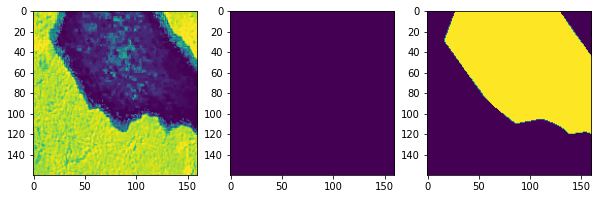

In [16]:
plot_data_generator(train_config=train_config, num_samples=1, fig_size=(10,5))

To train

In [11]:
res_config = train(train_config)

2021-10-27 15:10:34.766540: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-27 15:10:34.788832: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-10-27 15:10:34.789954: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5652f11688c0 executing computations on platform Host. Devices:
2021-10-27 15:10:34.789980: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-10-27 15:10:34.813096: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2021-10-27 15:10:34.867513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 15:10:34.868215: I tensorflow/core/common_runtime/g


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 160, 160, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (


Epoch 1/15
100/100 [==============================] - 748s 7s/step - loss: 0.3822 - mean_iou: 0.4545 - val_loss: 1.4134 - val_mean_iou: 0.5138

Epoch 00001: val_loss improved from inf to 1.41337, saving model to ./data/weights/UNet_fire_160_80_spe100_fire_water.h5
Epoch 2/15
100/100 [==============================] - 740s 7s/step - loss: 0.2586 - mean_iou: 0.5375 - val_loss: 15.0372 - val_mean_iou: 0.5385

Epoch 00002: val_loss did not improve from 1.41337
Epoch 3/15
100/100 [==============================] - 742s 7s/step - loss: 0.2275 - mean_iou: 0.5406 - val_loss: 5.0788 - val_mean_iou: 0.5419

Epoch 00003: val_loss did not improve from 1.41337
Epoch 4/15
100/100 [==============================] - 726s 7s/step - loss: 0.2148 - mean_iou: 0.5438 - val_loss: 0.1401 - val_mean_iou: 0.5544

Epoch 00004: val_loss improved from 1.41337 to 0.14010, saving model to ./data/weights/UNet_fire_160_80_spe100_fire_water.h5
Epoch 5/15
100/100 [==============================] - 755s 8s/step - loss:

Print some metrics

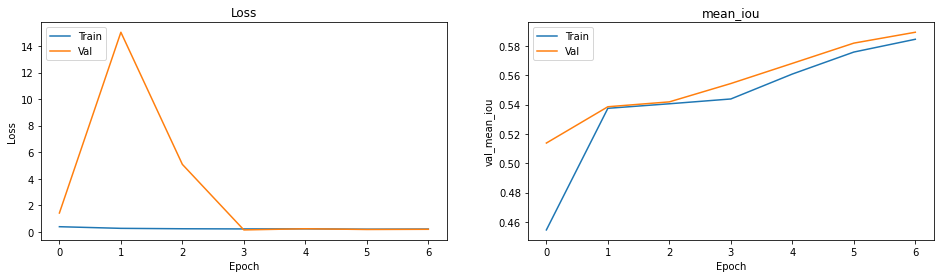

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_iou'])
plt.plot(res_config.history['val_mean_iou'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()